# WorkoutBuddy Database Exploration

This notebook provides comprehensive exploration and analysis of the WorkoutBuddy database.

## 📊 What you'll find here:
- Database connection and basic queries
- Exercise data analysis and visualization
- User and goal statistics (when available)
- Data quality checks
- Interactive visualizations
- Machine learning insights preparation

## 🚀 Setup and Imports

In [3]:
# Standard libraries
import os
import sys
import pandas as pd
import numpy as np
from collections import Counter
import warnings

warnings.filterwarnings("ignore")

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Database libraries
from sqlalchemy import create_engine, text
from sqlalchemy.orm import sessionmaker

# Configure plotting
plt.style.use("default")
sns.set_palette("husl")
%matplotlib inline

# Add app directory to path
sys.path.append("app")

print("✅ All imports successful!")

✅ All imports successful!


## 🔌 Database Connection

In [4]:
# Import configuration
try:
    from app.config import backend_config

    DATABASE_URL = backend_config.database.url
    print(f"📡 Using config database URL: {DATABASE_URL.split('@')[0]}@***")
except ImportError:
    # Fallback to environment variable
    DATABASE_URL = os.getenv(
        "DATABASE_URL", "postgresql://wojciechkowalinski@localhost/workoutbuddy"
    )
    print(f"📡 Using environment database URL: {DATABASE_URL.split('@')[0]}@***")

# Create engine and session
engine = create_engine(DATABASE_URL)
Session = sessionmaker(bind=engine)

# Test connection
try:
    with engine.connect() as conn:
        result = conn.execute(text("SELECT 1"))
        print("✅ Database connection successful!")
except Exception as e:
    print(f"❌ Database connection failed: {e}")
    raise

📡 Using environment database URL: postgresql://wojciechkowalinski@***
✅ Database connection successful!


## 🏋️ Exercise Data Analysis

In [5]:
# Load exercise data
exercises_query = """
SELECT 
    id,
    name,
    description,
    main_muscle_group,
    equipment,
    difficulty,
    form_cues,
    visual_reference
FROM exercises
ORDER BY name;
"""

exercises_df = pd.read_sql(exercises_query, engine)
print(f"🏋️ Loaded {len(exercises_df)} exercises")
print(f"📊 Data shape: {exercises_df.shape}")
exercises_df.head()

🏋️ Loaded 98 exercises
📊 Data shape: (98, 8)


,id,name,description,main_muscle_group,equipment,difficulty,form_cues,visual_reference
0,386,Archer Push-ups,Push-up shifting weight to one arm at a time,"Chest, Triceps, Core",None,Advanced,• Wide hand position • Shift weight to one arm...,Bodybuilding.com Archer Pushups
1,379,Assisted Dip Machine,Use machine assistance to perform dips,"Triceps, Chest",Assisted Dip Machine,Beginner,• Kneel on assistance pad • Hands on dip handl...,Bodybuilding.com Assisted Dips
2,378,Assisted Pull-up Machine,Use machine assistance to perform pull-ups,"Lats, Biceps",Assisted Pull-up Machine,Beginner,• Kneel on assistance pad • Grip pull-up bar •...,ExRx.net/WeightExercises/LatissimusDorsi/ASPullup
3,295,Barbell Back Squat,"Stand with barbell on shoulders, squat down ke...","Quadriceps, Glutes","Barbell, Squat Rack",Intermediate,"• Feet shoulder-width apart • Chest up, core t...",ExRx.net/WeightExercises/Quadriceps/BBSquat
4,299,Barbell Bench Press,"Lie on bench, press barbell from chest to full...","Chest, Triceps, Shoulders","Barbell, Bench",Intermediate,• Feet flat on floor • Arch in lower back • Re...,ExRx.net/WeightExercises/PectoralSternal/BBBen...


🎯 Top 10 Muscle Groups:
main_muscle_group
Quadriceps, Glutes               12
Lats, Biceps                      5
Biceps                            5
Triceps                           5
Lats, Rhomboids                   4
Triceps, Chest                    4
Shoulders, Triceps                4
Lats, Rhomboids, Middle Traps     3
Rear Delts, Rhomboids             3
Chest, Triceps                    3
Name: count, dtype: int64


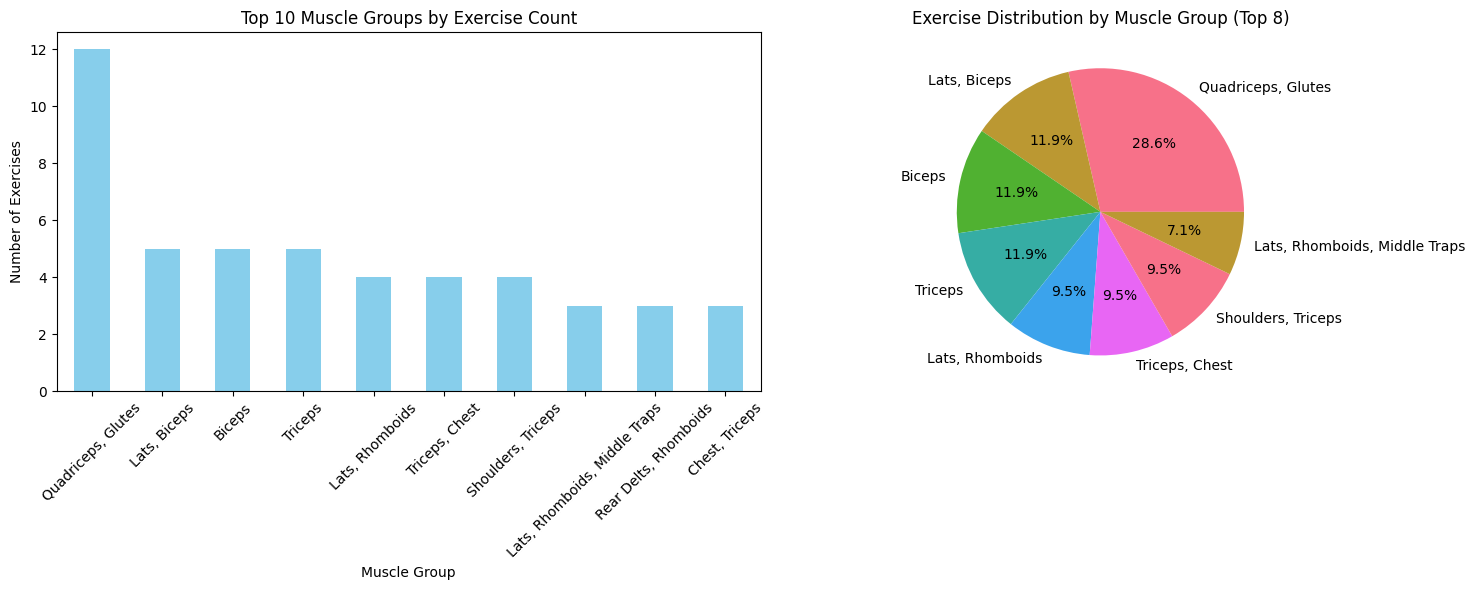

In [6]:
# Analyze muscle group distribution
muscle_groups = exercises_df["main_muscle_group"].value_counts()
print("🎯 Top 10 Muscle Groups:")
print(muscle_groups.head(10))

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart
muscle_groups.head(10).plot(kind="bar", ax=ax1, color="skyblue")
ax1.set_title("Top 10 Muscle Groups by Exercise Count")
ax1.set_xlabel("Muscle Group")
ax1.set_ylabel("Number of Exercises")
ax1.tick_params(axis="x", rotation=45)

# Pie chart
muscle_groups.head(8).plot(kind="pie", ax=ax2, autopct="%1.1f%%")
ax2.set_title("Exercise Distribution by Muscle Group (Top 8)")
ax2.set_ylabel("")

plt.tight_layout()
plt.show()

In [8]:
# Interactive equipment analysis
equipment_counts = exercises_df["equipment"].value_counts()
print("🛠️ Equipment Distribution:")
print(equipment_counts.head(10))

# Interactive plotly chart
fig = px.bar(
    x=equipment_counts.head(12).values,
    y=equipment_counts.head(12).index,
    orientation="h",
    title="Exercise Count by Equipment Type",
    labels={"x": "Number of Exercises", "y": "Equipment"},
    color=equipment_counts.head(12).values,
    color_continuous_scale="viridis",
)
fig.update_layout(height=500, showlegend=False)
fig.show()

🛠️ Equipment Distribution:
equipment
Dumbbells              18
Cable Machine          13
Barbell                10
None                    6
Dumbbells, Bench        4
Pull-up Bar             4
Barbell, Bench          4
Dumbbell                3
Barbell, Squat Rack     3
Bench/Step              2
Name: count, dtype: int64


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [6]:
# Exercise recommendation system
def get_exercises_by_criteria(
    muscle_group=None, equipment=None, difficulty=None, limit=5
):
    """
    Get exercises based on specified criteria
    """
    filtered_df = exercises_df.copy()

    if muscle_group:
        filtered_df = filtered_df[
            filtered_df["main_muscle_group"].str.contains(
                muscle_group, case=False, na=False
            )
        ]

    if equipment:
        filtered_df = filtered_df[
            filtered_df["equipment"].str.contains(equipment, case=False, na=False)
        ]

    if difficulty:
        filtered_df = filtered_df[
            filtered_df["difficulty"].str.contains(difficulty, case=False, na=False)
        ]

    return filtered_df.head(limit)[
        ["name", "main_muscle_group", "equipment", "difficulty"]
    ]


# Example recommendations
print("🏋️ Example Exercise Recommendations:")
print("\n1. Beginner Chest Exercises:")
print(
    get_exercises_by_criteria(muscle_group="Chest", difficulty="Beginner").to_string(
        index=False
    )
)

print("\n2. Dumbbell Exercises:")
print(get_exercises_by_criteria(equipment="Dumbbells", limit=8).to_string(index=False))

🏋️ Example Exercise Recommendations:

1. Beginner Chest Exercises:
                  name         main_muscle_group                equipment difficulty
  Assisted Dip Machine            Triceps, Chest     Assisted Dip Machine   Beginner
      Cable Crossovers                     Chest            Cable Machine   Beginner
   Chest Press Machine            Chest, Triceps      Chest Press Machine   Beginner
Decline Dumbbell Press      Lower Chest, Triceps Dumbbells, Decline Bench   Beginner
  Dumbbell Chest Press Chest, Triceps, Shoulders         Dumbbells, Bench   Beginner

2. Dumbbell Exercises:
                   name             main_muscle_group                equipment   difficulty
Bent-over Dumbbell Rows Lats, Rhomboids, Middle Traps                Dumbbells     Beginner
            Bicep Curls                        Biceps                Dumbbells     Beginner
 Bulgarian Split Squats            Quadriceps, Glutes    Dumbbells, Bench/Step Intermediate
 Decline Dumbbell Press        

## 🤖 Machine Learning Preparation

In [9]:
# Prepare data for ML algorithms
print("🤖 Preparing data for Machine Learning...")

# Encode categorical variables
from sklearn.preprocessing import LabelEncoder

ml_df = exercises_df.copy()

# Encode categorical features
le_muscle = LabelEncoder()
le_equipment = LabelEncoder()
le_difficulty = LabelEncoder()

ml_df["muscle_group_encoded"] = le_muscle.fit_transform(
    ml_df["main_muscle_group"].fillna("Unknown")
)
ml_df["equipment_encoded"] = le_equipment.fit_transform(
    ml_df["equipment"].fillna("Unknown")
)
ml_df["difficulty_encoded"] = le_difficulty.fit_transform(
    ml_df["difficulty"].fillna("Unknown")
)

# Add text features
ml_df["name_length"] = ml_df["name"].str.len()
ml_df["description_length"] = ml_df["description"].str.len()
ml_df["form_cues_length"] = ml_df["form_cues"].str.len()

print("\n📊 ML-Ready Features:")
feature_cols = [
    "muscle_group_encoded",
    "equipment_encoded",
    "difficulty_encoded",
    "name_length",
    "description_length",
    "form_cues_length",
]
print(ml_df[["name"] + feature_cols].head())

print("\n🎯 Potential ML Applications:")
print("- Exercise recommendation system")
print("- Difficulty prediction")
print("- Equipment-based exercise clustering")
print("- Muscle group classification")
print("- Workout plan generation")

🤖 Preparing data for Machine Learning...

📊 ML-Ready Features:
                       name  muscle_group_encoded  equipment_encoded  \
0           Archer Push-ups                     6                 28   
1      Assisted Dip Machine                    37                  0   
2  Assisted Pull-up Machine                    22                  1   
3        Barbell Back Squat                    29                  7   
4       Barbell Bench Press                     7                  4   

   difficulty_encoded  name_length  description_length  form_cues_length  
0                   1           15                  44               100  
1                   2           20                  38               107  
2                   2           24                  42               111  
3                   3           18                  80               124  
4                   3           19                  60               116  

🎯 Potential ML Applications:
- Exercise recommendatio

## 💾 Export Data

In [10]:
# Export processed data
output_dir = "data_exports"
os.makedirs(output_dir, exist_ok=True)

# Export main datasets
exercises_df.to_csv(f"{output_dir}/exercises_raw.csv", index=False)
ml_df.to_csv(f"{output_dir}/exercises_ml_ready.csv", index=False)

print(f"💾 Data exported to '{output_dir}/' directory")
print("✅ Analysis complete! Ready for ML model development.")

💾 Data exported to 'data_exports/' directory
✅ Analysis complete! Ready for ML model development.
